# **Sentiment Analysis Model**

This notebook details the process of preparing and training a sentiment classification model. The model is built using the IMDB dataset from Kaggle, and this notebook covers the steps involved in data loading, exploration, and preparing the data for training a sentiment analysis model.

In [ ]:
#Import important package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
df = pd.read_csv("imdb_data.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
# %load_ext cudf.pandas

# **Part1 - EDA**

In [ ]:
#Checking duplicates and handle them
print(df.duplicated().sum())

418


In [ ]:
#Handling them
df.drop_duplicates(inplace=True)

print(df.duplicated().sum())


0


<Axes: xlabel='sentiment', ylabel='count'>

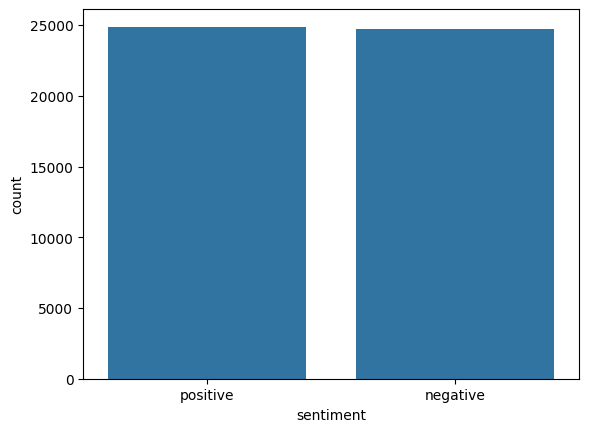

In [ ]:
#Class Distribution check
sns.countplot(x='sentiment', data=df)

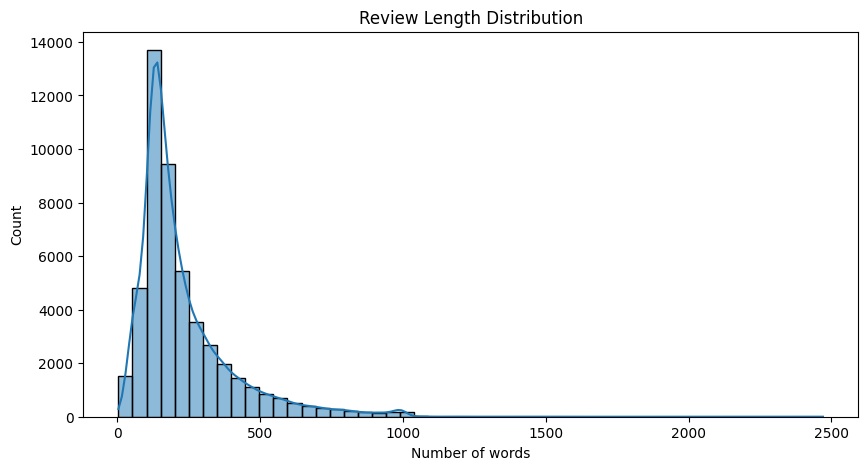

In [ ]:
# Review length distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].describe()

plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()


In [ ]:
# Sample reviews from each class
print("Sample Positive Reviews:")
print(df[df['sentiment'] == 'positive']['review'].sample(3).values)

print("Sample Negative Reviews:")
print(df[df['sentiment'] == 'negative']['review'].sample(3).values)


Sample Positive Reviews:
['A tour deforce! OK the kid that plays Oliver is a bit toooooo sweet! Starting with the great cinematography, color, costumes and most impressive performances this is a must see movie. I have seen several adaptations of this great novel, but this one stands above them all and its a musical to boot! It is a masterful Fagan, never leaving his character to do a song. You never really know if you like him or not, the same feeling I got in the book. In other versions you hate him from start to finish. Bill Sykes.... when you read the book hes a mean one, and so he is in this movie. Oliver Reed was masterful. His wife directed this masterpiece. I went and saw his last movie, Gladiator based on his many fine performances, not to see the headliners. The music fits the times and the mood. Who will buy this beautiful movie? You Should!'
 "at first I had the reaction a lot of people left with after seeing this: that shots of fat people sunbathing, etc were cheap shots in

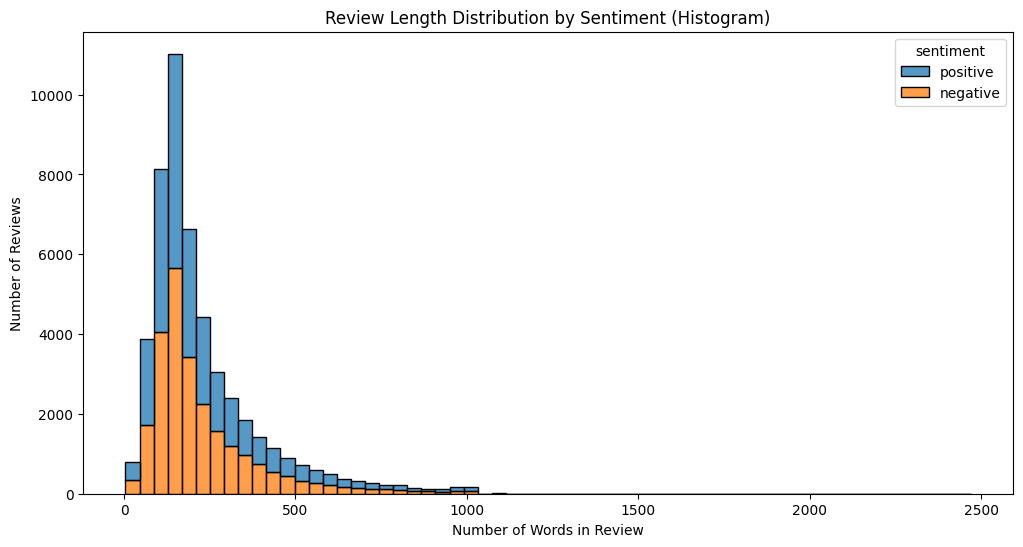

In [ ]:
# Compare review length across sentiment
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='review_length', hue='sentiment', bins=60, kde=False, multiple='stack')
plt.title("Review Length Distribution by Sentiment (Histogram)")
plt.xlabel("Number of Words in Review")
plt.ylabel("Number of Reviews")
plt.show()


In [ ]:
print("Max review length:", df['review_length'].max())
print("Mean review length:", df['review_length'].mean())
print("90th percentile length:", df['review_length'].quantile(0.9))


Max review length: 2470
Mean review length: 231.35016739945948
90th percentile length: 452.0


# **Splitting Classical model and Deep Learning models**

## **First classical model preprocess and training**

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.1 MB/s eta 0:00:00


In [ ]:
# Libraries necessary for preprocessing pipeline
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup

# --- NLTK Downloads ---
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    # Explicitly download the English version of the tagger
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')
# Explicitly download 'punkt_tab' to address the specific LookupError
try:
     nltk.data.find('tokenizers/punkt_tab')
except LookupError:
     nltk.download('punkt_tab')


# --- Initialization ---
# Initializing stopwords and lemmatization
stop_words = set(stopwords.words('english'))
negation_words = {"no", "nor", "not"}

stop_words = stop_words - negation_words

lemmatizer = WordNetLemmatizer()

# Helper function to map NLTK POS tags to WordNet tags
def get_wordnet_pos(tag):
    """Maps NLTK POS tags to WordNet POS tags."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# --- Preprocessing Function ---
def preprocess_for_classical(text):
    """
    Cleans and preprocesses text for classical NLP models.

    Steps:
    1. Remove HTML tags using BeautifulSoup
    2. Lowercasing
    3. Expanding contractions
    4. Removing non-alphabetic characters (excluding spaces)
    5. Tokenization
    6. Part-of-Speech (POS) tagging
    7. Lemmatization using POS tags
    8. Removing stop words (including updated negation list)
    9. Rejoining tokens into a string
    """
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    text = text.lower()

    text = contractions.fix(text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = nltk.word_tokenize(text, preserve_line=False)

    lemmatized_tokens = []
    # Check if tagged_tokens is empty before iterating
    if tokens:
        tagged_tokens = nltk.pos_tag(tokens)

        for word, tag in tagged_tokens:
            # Get the WordNet POS tag
            wn_tag = get_wordnet_pos(tag)
            # Lemmatize the word using the determined POS tag
            lemma = lemmatizer.lemmatize(word, wn_tag)
            # Append the lemma if it is not a stop word and is not just whitespace
            if lemma not in stop_words and lemma.strip() != '':
                 lemmatized_tokens.append(lemma)

    return ' '.join(lemmatized_tokens)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# --- Apply Preprocessing ---
# Apply the robust preprocessing function to the 'review' column
df['clean_review_classical'] = df['review'].apply(preprocess_for_classical)

# Display the head of the dataframe to show the new column
print(df[['review', 'clean_review_classical']].head())

# --- Verify Lemmatization (Optional, for checking) ---
# Select a review that you expect to see changes in due to lemmatization
sample_review_to_check = df['review'].iloc[0]
print("\n--- Checking Lemmatization on Sample Review ---")
print("Original:", sample_review_to_check)
print("Processed:", preprocess_for_classical(sample_review_to_check))

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                              clean_review_classical  
0  one reviewer mention watch oz episode hook rig...  
1  wonderful little production filming technique ...  
2  think wonderful way spend time hot summer week...  
3  basically family little boy jake think zombie ...  
4  petter matteis love time money visually stunni...  

--- Checking Lemmatization on Sample Review ---
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in r

In [ ]:
df.head()

,review,sentiment,review_length,clean_review_classical
0,One of the other reviewers has mentioned that ...,positive,307,one reviewer mention watch oz episode hook rig...
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,138,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love time money visually stunni...


In [ ]:
# TF-IDF Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Use both unigrams and bigrams, limit to top 10,000 features
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Apply TF-IDF to the cleaned reviews
X_tfidf = tfidf.fit_transform(df['clean_review_classical'])


In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['sentiment'])


In [ ]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4940
    Positive       0.89      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Accuracy: 0.8918


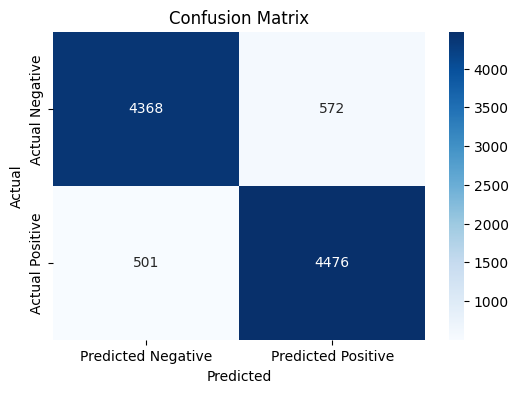

In [ ]:
# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = lr_model.predict(X_test)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# Support Vector Machine
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=['Negative', 'Positive']))


SVM Classification Report:

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      4940
    Positive       0.89      0.89      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [ ]:
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
print(cm_svm)


SVM Confusion Matrix:
[[4384  556]
 [ 569 4408]]


In [ ]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb, target_names=['Negative', 'Positive']))


Naive Bayes Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86      4940
    Positive       0.86      0.88      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Naive Bayes Confusion Matrix:")
print(cm_nb)


Naive Bayes Confusion Matrix:
[[4219  721]
 [ 608 4369]]


# **Deep Learning model**
## **Secong preprocessing which is for deep learning model**

In [35]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup # Import BeautifulSoup
import contractions # Import contractions library

# Ensure necessary resources (Redundant if already done, but good for standalone runs)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng') # Ensure English tagger
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')


# Stopwords setup with important negations kept
stop_words = set(stopwords.words('english'))
negation_words = {"not", "no", "nor"}

stop_words = stop_words.difference(negation_words)

# POS tag converter
def get_wordnet_pos(tag):
    """Maps NLTK POS tags to WordNet POS tags."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # Default to noun if no clear match, though might not be ideal for all words
        # The POS tagger is usually good, so the default might not be hit often
        return wordnet.NOUN

# Final DL preprocessing function
def preprocess_for_dl(df, max_len=200, num_words=20000):
    lemmatizer = WordNetLemmatizer()
    cleaned_reviews = []

    for text in df['review']:
        # 1. Remove HTML tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()

        # 2. Lowercase
        text = text.lower()

        # 3. Expand contractions using the library
        text = contractions.fix(text)

        # 4. Remove special characters, digits, and extra whitespace
        text = re.sub(r"[^a-zA-Z\s]", " ", text) # Keep spaces
        text = re.sub(r"\s+", " ", text).strip() # Remove extra spaces and trim

        # 5. Tokenize
        tokens = word_tokenize(text)

        # 6. POS tag
        pos_tags = pos_tag(tokens)

        lemmatized_tokens = []
        # 7. Lemmatize with POS and then remove stop words
        for word, tag in pos_tags:
            # Get the WordNet POS tag
            wn_tag = get_wordnet_pos(tag)
            # Lemmatize the word
            lemma = lemmatizer.lemmatize(word, wn_tag)
            # Append the lemma if it is not a stop word and is not just whitespace
            if lemma not in stop_words and lemma.strip() != '':
                 lemmatized_tokens.append(lemma)


        cleaned_reviews.append(" ".join(lemmatized_tokens))

    # Save cleaned column (optional, but good for inspection)
    df['clean_review'] = cleaned_reviews

    # Prepare for model
    texts = df['clean_review'].values
    labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values

    # Keras tokenization
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding
    X_dl = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y_dl = np.array(labels)

    return X_dl, y_dl, tokenizer, df


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
# Run the preprocessing
X_dl, y_dl, tokenizer, df_cleaned = preprocess_for_dl(df)

# Check outputs
print("Preprocessing complete!")
print("-" * 50)

# 1. Shape of processed data
print(f"Shape of X_dl (padded sequences): {X_dl.shape}")
print(f"Shape of y_dl (labels): {y_dl.shape}")
print("-" * 50)

# 2. Preview tokenized and padded sequence of first review
print("Example tokenized & padded sequence (first review):")
print(X_dl[0])
print("-" * 50)

# 3. Preview original vs cleaned review
print("Original review:")
print(df['review'].iloc[0])
print("\nCleaned review:")
print(df_cleaned['clean_review'].iloc[0])
print("-" * 50)

# 4. Preview tokenizer vocab size
print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)} (limited to top {tokenizer.num_words} words)")


Preprocessing complete!
--------------------------------------------------
Shape of X_dl (padded sequences): (49582, 200)
Shape of y_dl (labels): (49582,)
--------------------------------------------------
Example tokenized & padded sequence (first review):
[    5  1018   326    15  2611   178  1588   107   503   109    34    40
  1126  2611  4399 12044    24   459   104   107   263    14  1299     2
    23  4896  1976  9261    23   534    18  1595  1029   552   284   459
  3198   225    65   263   155  2611  6685    35 12045  5632  2160   467
     1   540  1220 17700   392  3849  1807   976  1781  1675   795   190
     1 13255     2   170  3686   392   248    49 11618  3479     1     1
  1133   830  2075     1   204  3939  6041  8904  6932  6686    52   113
   153    12    28   188   779    23   557    97    14    23    12     2
  1589   402   100   249  1275  2118   166   402   712   402   673  2611
     2   661   102    34   178    56   127  1126  1327  1907    31     2
    28  1355

In [41]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl
)

# Check the shapes of the split data
print("Shape of X_train_dl:", X_train_dl.shape)
print("Shape of X_test_dl:", X_test_dl.shape)
print("Shape of y_train_dl:", y_train_dl.shape)
print("Shape of y_test_dl:", y_test_dl.shape)


Shape of X_train_dl: (39665, 200)
Shape of X_test_dl: (9917, 200)
Shape of y_train_dl: (39665,)
Shape of y_test_dl: (9917,)


In [ ]:
# Build & Train Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_and_train_lstm_model(X_train, y_train,
                                vocab_size=20000,
                                embedding_dim=128,
                                max_len=200,
                                epochs=5,
                                batch_size=128, dropout=0.0, activation='tanh', units=128, dense_units=64):
    # Build model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        LSTM(units, activation=activation, return_sequences=False),
        Dropout(dropout),
        Dense(dense_units, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )

    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5102 - loss: 0.6909 - val_accuracy: 0.5955 - val_loss: 0.6484
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6108 - loss: 0.6475 - val_accuracy: 0.5013 - val_loss: 0.7037
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5246 - loss: 0.6859 - val_accuracy: 0.5848 - val_loss: 0.6767
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7890 - loss: 0.4633 - val_accuracy: 0.8724 - val_loss: 0.2986
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9316 - loss: 0.1893 - val_accuracy: 0.8809 - val_loss: 0.3012


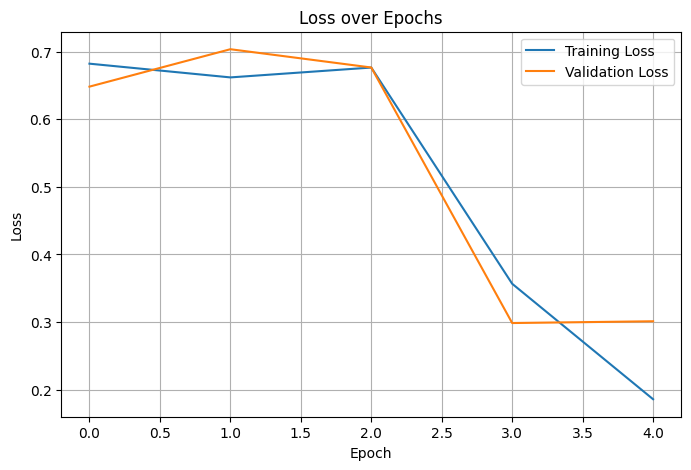

In [ ]:
# first trail with plain model no fine tuning
model, history = build_and_train_lstm_model(X_train_dl, y_train_dl, epochs=5)

Epoch 1/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4998 - loss: 0.6933 - val_accuracy: 0.7053 - val_loss: 0.9040
Epoch 2/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5284 - loss: 0.7168 - val_accuracy: 0.5540 - val_loss: 0.6660
Epoch 3/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5548 - loss: 0.6641 - val_accuracy: 0.5449 - val_loss: 0.6648
Epoch 4/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5783 - loss: 0.6095 - val_accuracy: 0.5376 - val_loss: 0.6850
Epoch 5/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6644 - loss: 0.5397 - val_accuracy: 0.8470 - val_loss: 0.4040
Epoch 6/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8979 - loss: 0.2740 - val_accuracy: 0.8629 - val_loss: 0.3467


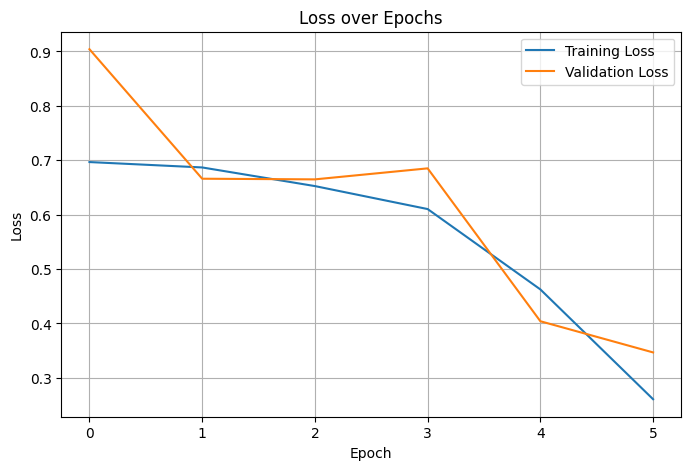

In [ ]:
# second trial for the model adding dropouts one of 0.3
model_2, history_2 = build_and_train_lstm_model(X_train_dl, y_train_dl, epochs=6, dropout=0.3)


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5084 - loss: 0.6930 - val_accuracy: 0.5272 - val_loss: 0.6875
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5487 - loss: 0.6656 - val_accuracy: 0.7766 - val_loss: 0.5444
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7951 - loss: 0.4962 - val_accuracy: 0.5557 - val_loss: 0.7151
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5549 - loss: 0.6531 - val_accuracy: 0.8207 - val_loss: 0.4262
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8779 - loss: 0.3043 - val_accuracy: 0.8681 - val_loss: 0.3523
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9502 - loss: 0.1408 - val_accuracy: 0.8776 - val_loss: 0.3422
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9753 - loss: 0.0865 - val_accuracy: 0.8728 - val_loss: 0.4142
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9866 - loss: 0.0532 - val_ac

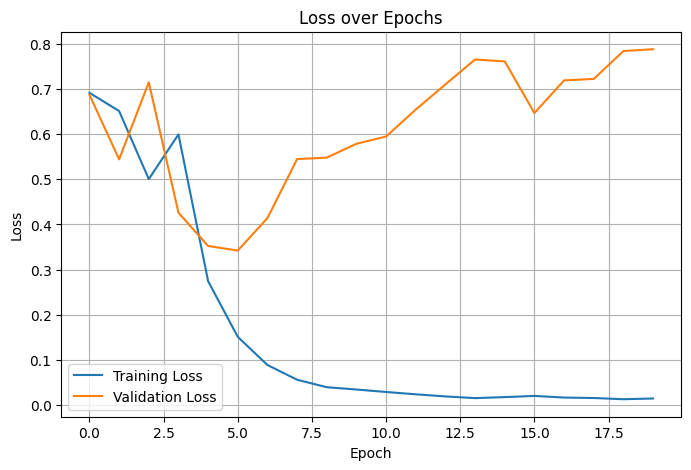

In [ ]:
# Third Trial
model_3, history_3 = build_and_train_lstm_model(X_train_dl, y_train_dl, epochs=20)

# **Using Glove and Attention Layer**

In [42]:
def load_glove_embeddings(glove_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    word_index = tokenizer.word_index
    num_words = min(len(word_index) + 1, 20000)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i < 20000:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [43]:
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, inputs):
        e = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(e, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_and_train_lstm_model_with_glove_attention(X_train, y_train, X_val, y_val,
                                                    tokenizer, embedding_matrix,
                                                    vocab_size=20000,
                                                    embedding_dim=100,
                                                    max_len=200,
                                                    units=64,
                                                    dense_units=32,
                                                    dropout=0.3,
                                                    batch_size=64,
                                                    epochs=10,
                                                    learning_rate=0.001):

    # Define model
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False)(input_layer)

    lstm_out = LSTM(units, return_sequences=True)(embedding_layer)
    attention_out = AttentionLayer()(lstm_out)

    x = Dropout(dropout)(attention_out)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=1)
    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history


In [45]:
embedding_matrix = load_glove_embeddings("glove.6B.100d.txt", tokenizer)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 130s 204ms/step - accuracy: 0.7149 - loss: 0.5412 - val_accuracy: 0.8352 - val_loss: 0.3713
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 149s 216ms/step - accuracy: 0.8420 - loss: 0.3644 - val_accuracy: 0.8578 - val_loss: 0.3275
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - accuracy: 0.8637 - loss: 0.3223 - val_accuracy: 0.8706 - val_loss: 0.3048
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 142s 215ms/step - accuracy: 0.8759 - loss: 0.2958 - val_accuracy: 0.8642 - val_loss: 0.3117
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 130s 196ms/step - accuracy: 0.8832 - loss: 0.2866 - val_accuracy: 0.8829 - val_loss: 0.2809
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - accuracy: 0.8896 - loss: 0.2722 - val_accuracy: 0.8843 - val_loss: 0.2795
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 155s 217ms/step - accuracy: 0.8998 - loss: 0.2505 - val_accuracy: 0.8853 - val_loss: 0.2770
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 129s 197ms/step - accuracy: 0.9034 -

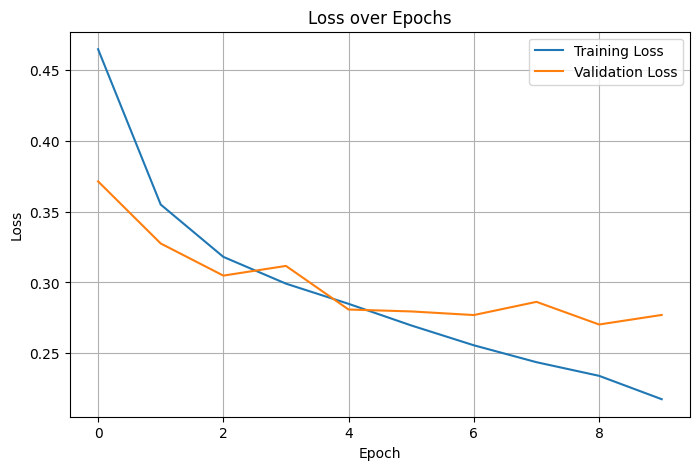

In [46]:
model_4, history_4 = build_and_train_lstm_model_with_glove_attention(
    X_train_dl, y_train_dl,
    X_test_dl, y_test_dl,
    tokenizer,
    embedding_matrix
)


In [48]:
test_loss, test_accuracy = model_4.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Test Accuracy: 0.8885, Test Loss: 0.2703


In [52]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def predict_and_evaluate(model, X_test, y_test, threshold=0.5):
    """
    Predicts sentiment on the test set and evaluates model performance.

    Args:
        model: Trained Keras model.
        X_test: Preprocessed test features (e.g., padded sequences).
        y_test: True test labels (0 or 1).
        threshold: Decision threshold for converting probabilities to class labels.

    Returns:
        y_pred_labels: Predicted class labels (0 or 1).
    """
    # Get probability predictions
    y_pred_probs = model.predict(X_test, verbose=0)

    # Convert probabilities to binary labels
    y_pred_labels = (y_pred_probs >= threshold).astype(int)

    # Print metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_labels))

    return y_pred_labels


In [53]:
y_pred = predict_and_evaluate(model_4, X_test_dl, y_test_dl)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4940
           1       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Confusion Matrix:
[[4330  610]
 [ 496 4481]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 216s 688ms/step - accuracy: 0.6048 - loss: 0.6515 - val_accuracy: 0.7612 - val_loss: 0.5035
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 199s 640ms/step - accuracy: 0.7837 - loss: 0.4696 - val_accuracy: 0.7992 - val_loss: 0.4367
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 192s 610ms/step - accuracy: 0.8014 - loss: 0.4327 - val_accuracy: 0.7881 - val_loss: 0.4603
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 203s 613ms/step - accuracy: 0.8098 - loss: 0.4182 - val_accuracy: 0.7991 - val_loss: 0.4298
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 206s 628ms/step - accuracy: 0.8213 - loss: 0.4013 - val_accuracy: 0.8248 - val_loss: 0.3922


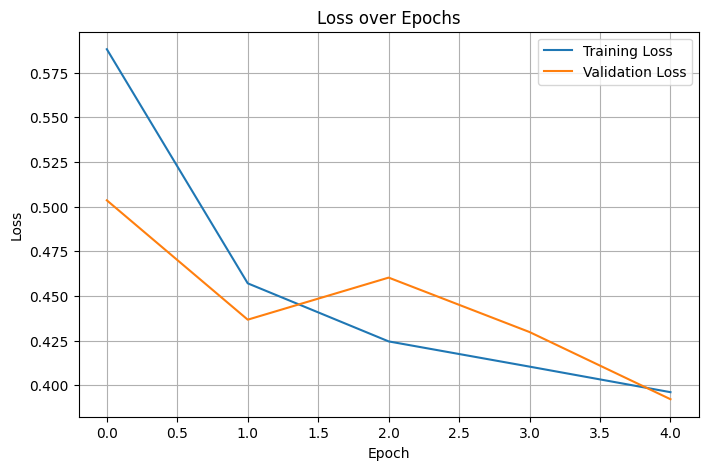

In [49]:
model_5, history_5 = build_and_train_lstm_model_with_glove_attention(X_train_dl, y_train_dl,
    X_test_dl, y_test_dl,
    tokenizer,
    embedding_matrix,
    units=128,
    dense_units=64,
    dropout=0.3,
    batch_size=128,
    epochs=5,
    learning_rate=0.0001
    )

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 200s 632ms/step - accuracy: 0.6269 - loss: 0.6453 - val_accuracy: 0.7781 - val_loss: 0.4790
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 199s 622ms/step - accuracy: 0.7906 - loss: 0.4610 - val_accuracy: 0.8013 - val_loss: 0.4307
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 207s 640ms/step - accuracy: 0.8070 - loss: 0.4247 - val_accuracy: 0.8075 - val_loss: 0.4173
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 196s 621ms/step - accuracy: 0.8154 - loss: 0.4100 - val_accuracy: 0.8177 - val_loss: 0.4101
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 191s 618ms/step - accuracy: 0.8228 - loss: 0.3979 - val_accuracy: 0.8268 - val_loss: 0.3873
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 203s 622ms/step - accuracy: 0.8315 - loss: 0.3842 - val_accuracy: 0.8308 - val_loss: 0.3783
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 203s 626ms/step - accuracy: 0.8353 - loss: 0.3740 - val_accuracy: 0.8384 - val_loss: 0.3661
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 201s 623ms/step - accuracy: 0.8449 - loss: 0.36

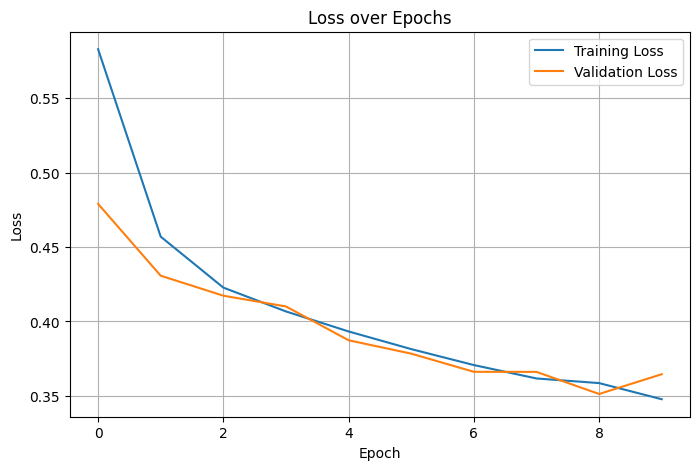

In [50]:
model_6, history_6 = build_and_train_lstm_model_with_glove_attention(X_train_dl, y_train_dl,
    X_test_dl, y_test_dl,
    tokenizer,
    embedding_matrix,
    units=128,
    dense_units=64,
    dropout=0.3,
    batch_size=128,
    epochs=10,
    learning_rate=0.0001
    )

In [51]:
test_loss, test_accuracy = model_6.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8493, Test Loss: 0.3512


In [54]:
y_pred = predict_and_evaluate(model_6, X_test_dl, y_test_dl)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4940
           1       0.84      0.86      0.85      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917

Confusion Matrix:
[[4151  789]
 [ 705 4272]]


In [55]:
# Save my models as pickle
import pickle

# For example, saving the Logistic Regression model
lr_model_filename = "logistic_regression_model.pkl"

# For example, saving the best performing deep learning model (e.g., model_6)
dl_model_filename = "lstm_glove_attention_model.pkl"


In [56]:
# Save the Logistic Regression model
with open(lr_model_filename, 'wb') as file:
    pickle.dump(lr_model, file)

# Save the deep learning model (replace model_6 with the model you want to save)
with open(dl_model_filename, 'wb') as file:
    pickle.dump(model_4, file)

print(f"Logistic Regression model saved to {lr_model_filename}")
print(f"Deep Learning model saved to {dl_model_filename}")

Logistic Regression model saved to logistic_regression_model.pkl
Deep Learning model saved to lstm_glove_attention_model.pkl
